# Model Building: Position Players (not catchers or pitchers)


### Overview: 
            - Load Libraries and csvs created from earlier notebooks
            - Data filtering to include players HOF eligible.
            - Exploratory Analysis
            - Train Model
            - Use oversampling on minority class
            - Feature Selection 
            

In [1]:
import pandas as pd
import numpy as np 
from plotnine import *
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

dfO = pd.read_csv('~/jupyter/cs2019_Group4/GroupProducts/dfO')

The HOFeligible variable is removed so the correlaion matrix will be informative. Remove rows with 'infinity' values and fill null values with 0s (these come from calculations that involve players with not many values in specific columns / don't reach a minimum # of records for statistical significance)

In [2]:
dfO = dfO.replace([np.inf, -np.inf], np.nan)
#fill NaNs with 0
dfO = dfO.fillna(0)


## Train and Test sets:

The next step is to subset our dataframe to show only those individuals who are Hall of Fame eligible. Since we are testing for who is in the hall of fame, players not eligible for the hall of fame in this logistic regression creation will skew our results.

The next step is to create train and test sets. The training set will be used to train the model and have the alogrithm learn on the data to help make predictions. The test dataset is a dataset used to provide an unbiased evaluation of a final model fit on the training dataset.

We get rid of the playerID and fullName field because these variables cannot be used in prediction

In [3]:
#Defining variables, train and test sets 
feature_cols = dfO.drop(['inducted'], axis = 1).columns
X = dfO.loc[dfO.HOFeligible == 1, feature_cols]
y = dfO.loc[dfO.HOFeligible == 1, 'inducted']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)

#get rid of text columns as this will ruin the model
X_train = X_train.drop(['playerID', 'fullName'], axis=1)
X_test = X_test.drop(['playerID', 'fullName'], axis=1)

### Oversampling on the datasets:

We need to deal with our imbalanced dfs by oversampling (creating an a 50/50 split of HoF inductees and non-inductees) this will improve our model. Oversampling can be a good choice when you don’t have a ton of data to work with. After resampling we have an equal ratio of data points for each class


In [4]:
# Oversampling technique:

from sklearn.utils import resample

# # Separate input features and target
# y = dfO.inducted 
# X = dfO.drop('inducted', axis=1)

# # setting up testing and training sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_HoF = X[X.inducted==0]
HoF = X[X.inducted==1]

# upsample minority
HoF_upsampled = resample(HoF,
                          replace=True, # sample with replacement
                          n_samples=len(not_HoF), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_HoF, HoF_upsampled])

# check new class counts
upsampled.inducted.value_counts()

1.0    922
0.0    922
Name: inducted, dtype: int64

We can see from the output that there are an equal distribution of HoF inductees and non-inductees

In [5]:

y_train = upsampled.inducted
X_train = upsampled.drop('inducted', axis=1)

The above code reorganizes the X_train and y_train to look at the upsampled dataset rather than the original split

## Modeling:


### Logistic Regression - 

#### Defining the Model Metrics: 

##### Accuracy = TP+TN/TP+FP+FN+TN
Accuracy: Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. 

##### Precision = TP/TP+FP

Precision: Precision is about being precise, i.e., how accurate your model is. 
In other words, you can say, when a model makes a prediction, how often it is correct. 
In this prediction case, the Logistic Regression model predicted a player going to the HoF, 
that patients have 41% of the time.

##### Recall = TP/TP+FN

Recall:  Recall is the ratio of correctly predicted positive observations to the all observations in actual class - HoF. The question recall answers is: Of all HoFers, how many did we label? We have got recall of 0.818 which is good for this model as it’s above 0.5. If there are players who will make the HoF in the test set, our Logistic Regression model can identify it 81% of the time. 


##### F1 Score = 2*(Recall * Precision) / (Recall + Precision)
F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 

In [6]:
# trying logistic regression 

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, upsampled_pred ))
print("Precision:",metrics.precision_score(y_test, upsampled_pred ))
print("Recall:",metrics.recall_score(y_test, upsampled_pred ))
print("f1_score:",metrics.f1_score(y_test, upsampled_pred ))


Accuracy: 0.9072398190045249
Precision: 0.43548387096774194
Recall: 0.8181818181818182
f1_score: 0.5684210526315789


# Logistic Regression creation  

See notebook Milestone 4 dfO for how we came to this conclusion.

In [7]:
#Better Logistic Regression Model w/o summary stats
feature_cols = ['Linked to Steroids', 'awardCount',
       'G', 'HR', 'RBI', 'SB', 
       'IBB', 'HBP', 'RC',
       'ISO']
X_train2 = X_train[feature_cols]
X_test2 = X_test[feature_cols]

logreg = LogisticRegression()
logreg.fit(X_train2,y_train)
results = logreg.fit(X_train2,y_train)

y_pred=logreg.predict(X_test2)


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #correctly predicted observes / total observes
print("Precision:",metrics.precision_score(y_test, y_pred)) # correctly predicted  pos observes / total predicted positives 
print("Recall:",metrics.recall_score(y_test, y_pred)) # correctly predicted pos / total observations
print("f1_score:",metrics.f1_score(y_test, y_pred)) #weighted avg of prec and recall

Accuracy: 0.9140271493212669
Precision: 0.4576271186440678
Recall: 0.8181818181818182
f1_score: 0.5869565217391305


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Comparing current model to original logistic regression:

As we can see with the results of the final logistic regression model above, our accuracy = 0.91, precision = 0.46, Recall = 0.82, and f1_score = 0.59.
This compares to our original logistic regression model as follows: Accuracy: 0.91, Precision: 0.44, Recall: 0.82, f1_score: 0.57


Our refined model shows an increase in all categories. Precision showed an increase .02 and f1 score .02. Recall and accuracy stayed the same

It’s a good rule of thumb to try a variety of algorithms, 
it can be especially beneficial with imbalanced datasets. 
Decision trees frequently perform well on imbalanced data. 
They work by learning a hierarchy of if/else questions and this can force both classes to be addressed.

In [8]:
# random forest / decision tree

from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, rfc_pred ))
print("Precision:",metrics.precision_score(y_test, rfc_pred ))
print("Recall:",metrics.recall_score(y_test, rfc_pred ))
print("f1_score:",metrics.f1_score(y_test, rfc_pred ))

Accuracy: 0.9502262443438914
Precision: 0.6896551724137931
Recall: 0.6060606060606061
f1_score: 0.6451612903225807


# Predicting players who reach Hall of Fame or not

The following creates the hof_proj variable which places players into a class 0 or 1 based on whether the model predicts the player will make it into that hall or not. 1 signifys making it to the HoF

In [9]:
X_test2 = dfO[feature_cols]
dfO['hof_proj']=logreg.predict(X_test2)

#moving code to beginning of dateframe
cols = list(dfO) 
cols.insert(2, cols.pop(cols.index('hof_proj')))
cols
dfO = dfO.loc[:, cols]

# Predicting % chance to make the Hall of Fame

The following code defines the % chance the player will make the HoF based on our model

In [10]:
dfO['hof_perc'] = np.round(logreg.predict_proba(X_test2)[:,1], 4)*100

#moving code to beginning of dateframe
cols = list(dfO) 
cols.insert(2, cols.pop(cols.index('hof_perc')))
cols
dfO = dfO.loc[:, cols]
dfO.head()

,playerID,fullName,hof_perc,hof_proj,inducted,InnOuts,FPCT,RF,TC,ActiveFlag,...,RC,BA,OBP,SLG,OPS,wOBA,ISO,Glf,Gcf,Grf
0,aaronha01,Hank Aaron,99.87,1.0,1.0,78414.0,0.982020,2.708126,8009.0,0,...,2576.0,0.305,0.374,0.555,0.929,0.408,0.250,131.0,0.0,116.0
1,abbated01,Ed Abbaticchio,1.52,0.0,0.0,21696.0,0.930860,5.277793,4556.0,0,...,315.0,0.254,0.325,0.325,0.650,0.295,0.071,0.0,2.0,1.0
2,abbeych01,Charlie Abbey,1.61,0.0,0.0,11781.0,0.910072,2.319328,1112.0,0,...,243.0,0.281,0.351,0.404,0.755,0.335,0.123,92.0,184.0,173.0
3,abbotku01,Kurt Abbott,0.37,0.0,0.0,13474.0,0.965336,4.408490,2279.0,0,...,260.0,0.256,0.305,0.423,0.728,0.320,0.167,0.0,0.0,0.0
4,abreubo01,Bobby Abreu,89.38,1.0,0.0,54870.0,0.982456,2.011591,4161.0,0,...,1596.0,0.291,0.395,0.475,0.870,0.386,0.184,0.0,0.0,0.0


What is Mike Trout's HoF likelihood?

In [11]:
dfO[dfO['fullName'] == 'Mike Trout']

,playerID,fullName,hof_perc,hof_proj,inducted,InnOuts,FPCT,RF,TC,ActiveFlag,...,RC,BA,OBP,SLG,OPS,wOBA,ISO,Glf,Gcf,Grf
2136,troutmi01,Mike Trout,52.08,1.0,0.0,26363.0,0.993658,2.567576,2523.0,1,...,914.0,0.307,0.416,0.573,0.989,0.434,0.266,0.0,0.0,0.0


52.08% chance of making HOF

# In order to recombine the data, we are saving out to csv the end result of our logistic regressions

In [12]:
dfO.to_csv('dfOlog', index=False)

In [13]:
results = sm.Logit(y_train, X_train2).fit(method = 'nm', maxiter=1000)

print(results.summary())
print("--"*50)
print('Confidence Interval:')
results.conf_int()

                           Logit Regression Results                           
Dep. Variable:               inducted   No. Observations:                 1844
Model:                          Logit   Df Residuals:                     1834
Method:                           MLE   Df Model:                            9
Date:                Thu, 25 Jul 2019   Pseudo R-squ.:                  0.5595
Time:                        14:04:35   Log-Likelihood:                -563.02
converged:                      False   LL-Null:                       -1278.2
                                        LLR p-value:                2.199e-302
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Linked to Steroids     0.4889      0.569      0.859      0.391      -0.627       1.605
awardCount             0.3309      0.028     11.941      0.000       0.277       0.385
G                   

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,0,1
Linked to Steroids,-0.627122,1.604943
awardCount,0.276608,0.385241
G,-0.007000,-0.005585
HR,-0.020550,-0.013502
RBI,0.002053,0.004275
SB,0.000436,0.002492
IBB,0.003864,0.014722
HBP,-0.003832,0.003713
RC,0.007877,0.010742
ISO,-4.623172,3.195271


In [14]:
err_series = results.params - results.conf_int()[0]

coef_df = pd.DataFrame({'coef': (results.params.values),
                        'err': (err_series.values),
                        'varname': err_series.index.values
                       })

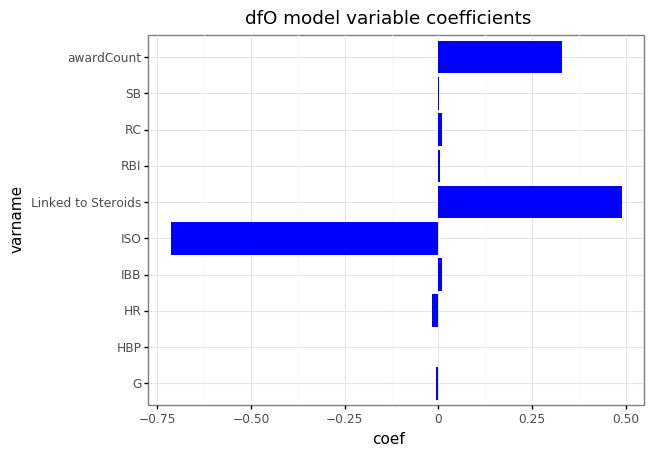

<ggplot: (-9223363253582890033)>

In [15]:
g1 = ggplot(coef_df, aes(x='varname', y='coef')) +  geom_bar(stat="identity", fill='blue', position=position_dodge(width=0.9),width=0.9) 
g1 = g1 +  coord_flip() + theme_bw() +  labs(title='dfO model variable coefficients')
g1

# Model Validation

## Cumulative Gains Curve / Lift Chart

The cumulative gains chart shows the percentage of the overall number of cases in a given category "gained" by targeting a percentage of the total number of cases. 

The diagonal line is the "baseline" curve (expected percentage of inductees correctly selected at random); if you select 10% of the cases from the scored dataset at random, you would expect to "gain" approximately 10% of all of the cases that actually take the category 'inducted'. 

The orange 'Class 1.0' curve shows comparatively how much percent gain we can attribute to the model 

Gain = (Expected outcome of HoF induction Using Predictive Model) / (Expected outcome of HoF induction at Random)

Gain > 1 means the results from the predictive model are better than random

### NEED TO RUN THIS COMMAND IN TERMINAL: pip install scikit-plot

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


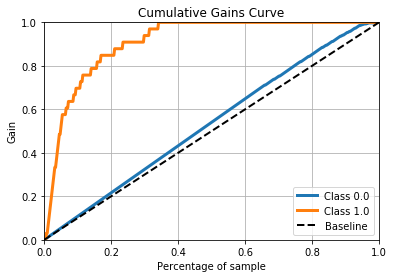

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

nb = GaussianNB()
nb.fit(X_train, y_train)
predicted_probas = nb.predict_proba(X_test)

import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

The example above shows how much better the predictive model is at identifying HoF inductees compared to baseline. 
The model does not do that much better at identifying those who will not make the HoF, but this is fine since this is not within the scope of this project.

### Roc Curve

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. 
ROC is a probability curve and AUC represents degree or measure of separability. 
It tells how much model is capable of distinguishing between classes. 
Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train/Test split results:
LogisticRegression accuracy is 0.907
LogisticRegression log_loss is 0.214
LogisticRegression auc is 0.965


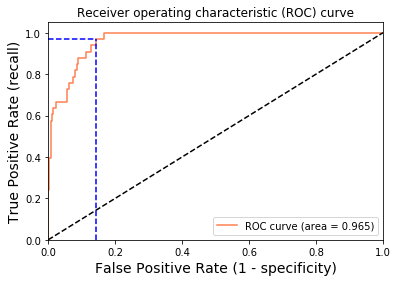

Using a threshold of 0.270 guarantees a sensitivity of 0.970 and a specificity of 0.856, i.e. a false positive rate of 14.43%.


In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss


# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

#### Use the describe() function to see what the 25th percentile is for a set of stats. This will be our 'threshold' to make the HoF (a player should reach the threshold in order to have a good change of making the HoF

Change the data type to conduct describe analysis

In [19]:
#tranforming the inducted column in each df to factor so only two colors are shown on specific plots
X['inducted'] = X['inducted'].astype(object)

In [20]:
dfO[dfO['inducted'] == 1][['awardCount', 'HR']].describe()

,awardCount,HR
count,144.000000,144.000000
mean,11.159722,222.527778
std,9.543176,184.480596
min,0.000000,12.000000
25%,4.000000,72.500000
50%,10.000000,148.500000
75%,16.000000,359.500000
max,39.000000,755.000000


A player must win at least 4 awards and hit at least 72.5 career HRs to have a good chance of making HoF

#### Using 25th percentile for minimum HoF worthy statistics

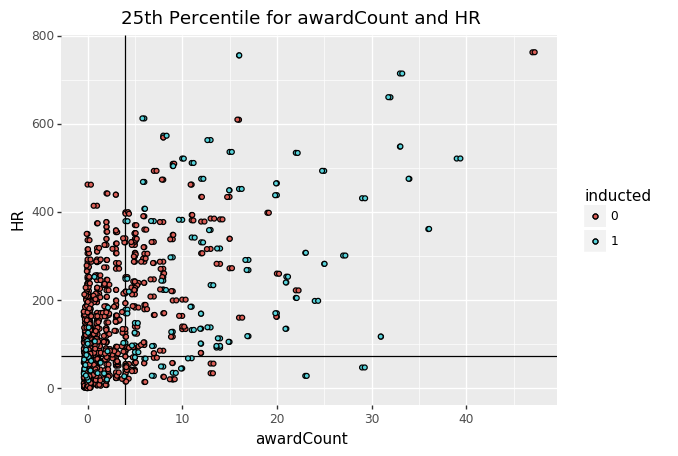

<ggplot: (-9223363253585498273)>

In [22]:
X['inducted'] = X['inducted'].astype(object)
ggplot(X, aes(x = 'awardCount', y = 'HR', fill='inducted'))  \
+ geom_vline(xintercept=4) + geom_hline(yintercept=72.5) + geom_point() + geom_jitter() + ggtitle("25th Percentile for awardCount and HR")
#outline steroids in yellow


#use different dataframes to show viz's for each ()



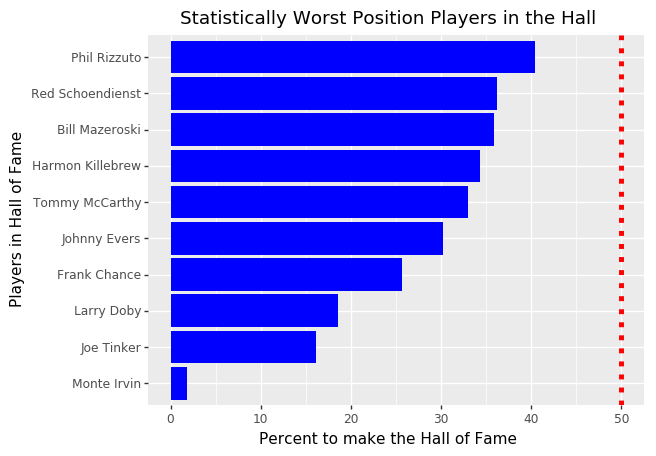

<ggplot: (8783269304822)>

In [25]:
bot_dfO = dfO[dfO.inducted == 1].sort_values(by='hof_perc', ascending=True).head(10)
bot_dfO_list = bot_dfO.sort_values(by='hof_perc', ascending=True)['fullName'].tolist()
bot_dfO_cat = pd.CategoricalDtype(categories=bot_dfO_list, ordered=True)
bot_dfO['name_cat'] = bot_dfO['fullName'].astype(str).astype(bot_dfO_cat)

g1 = ggplot(bot_dfO, aes(x='name_cat', y='hof_perc'))  + geom_bar(stat='identity', fill='blue') + coord_flip()
g1 = g1 + ylab("Percent to make the Hall of Fame") + xlab("Players in Hall of Fame")
g1 = g1 + ggtitle("Statistically Worst Position Players in the Hall")


g1+ geom_hline(yintercept = 50, linetype="dotted", color="red",size = 2)

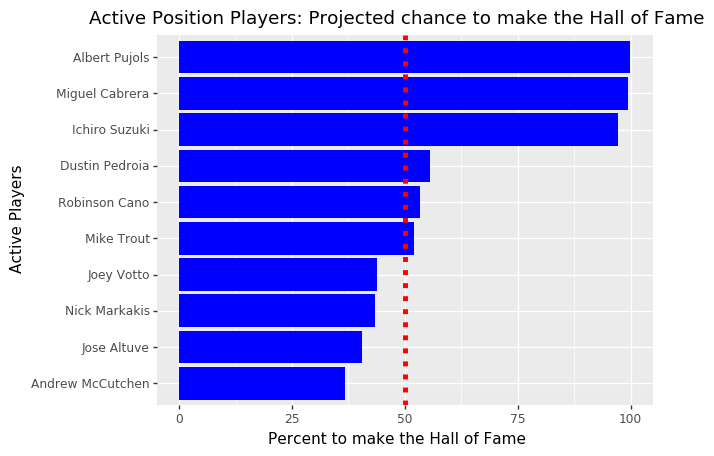

<ggplot: (8783221883568)>

In [26]:
People = pd.read_csv('~/jupyter/cs2019_Group4/data/core/People.csv')
People = People.drop(['birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState','birthCity','deathYear','deathMonth'], axis=1)
People = People.drop(['deathDay', 'deathCountry', 'deathState', 'deathCity', 'weight','height','bats','throws'], axis=1)
People = People.drop(['retroID', 'bbrefID'], axis=1)
People = People.drop(['nameFirst', 'nameLast', 'nameGiven','debut'], axis=1)
People['finalGame']= pd.to_datetime(People['finalGame'])
People['ActiveFlag'] = np.where((People['finalGame'].dt.year==datetime.datetime.now().year), 1, 0)#making boolean flag to indicate if a player is still playing
People = People[People['ActiveFlag'] ==1]
People.head()
dfOvisactive= People.merge(dfO, on='playerID', how='inner')
dfOvisactive.to_csv('dfOvalidator', index=False)
act_dfO = dfOvisactive.sort_values(by='hof_perc', ascending=False).head(10)
act_dfO_list = act_dfO.sort_values(by='hof_perc', ascending=True)['fullName'].tolist()
act_dfO_list
act_dfO_cat = pd.CategoricalDtype(categories=act_dfO_list, ordered=True)
act_dfO['name_cat'] = act_dfO['fullName'].astype(str).astype(act_dfO_cat)

g2 = ggplot(act_dfO, aes(x='name_cat', y='hof_perc'))  + geom_bar(stat='identity', fill='blue') + coord_flip()
g2 = g2 + ylab("Percent to make the Hall of Fame") + xlab("Active Players")
g2 = g2 + ggtitle("Active Position Players: Projected chance to make the Hall of Fame") 

g2+ geom_hline(yintercept = 50, linetype="dotted", color="red",size = 2)

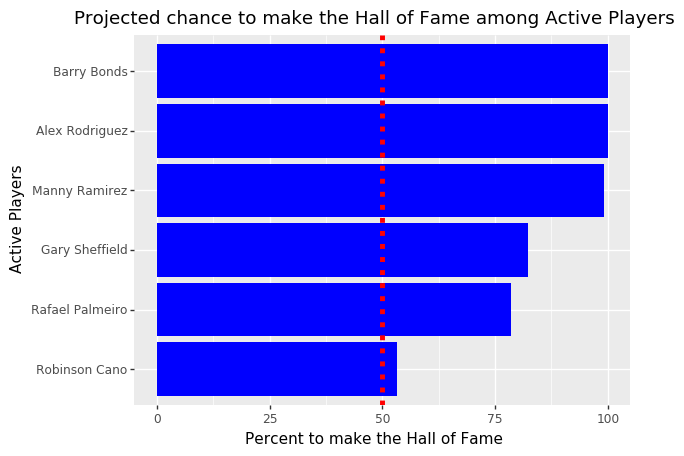

<ggplot: (-9223363253632984376)>

In [27]:
hof = dfO[dfO.hof_proj == 1] 
act_dfP = hof[hof['Linked to Steroids'] == 1].sort_values(by='hof_perc', ascending=False).head(10)
act_dfP_list = act_dfP.sort_values(by='hof_perc', ascending=True)['fullName'].tolist()
act_dfP_list
act_dfP_cat = pd.CategoricalDtype(categories=act_dfP_list, ordered=True)
act_dfP['name_cat'] = act_dfP['fullName'].astype(str).astype(act_dfP_cat)

g2 = ggplot(act_dfP, aes(x='name_cat', y='hof_perc'))  + geom_bar(stat='identity', fill='blue') + coord_flip()
g2 = g2 + ylab("Percent to make the Hall of Fame") + xlab("Active Players")
g2 = g2 + ggtitle("Projected chance to make the Hall of Fame among Active Players")

g2+ geom_hline(yintercept = 50, linetype="dotted", color="red",size = 2)